# 평가 기준
    1. 자기만의 카메라앱 기능 구현을 환수하였다
    2. 스티커 이미지를 정확한 원본 위치에 반영하였다.
    3. 카메라 스티커앱을 다양한 원본 이미지에 적용했을때 문제점을 체계적으로 분석하였다.
-------------------------------


# Step 1. 스티커 구하기 or 만들기
--------------------------------------------------
# Step 2. 얼굴 검출& 랜드마크 검출하기

    1) bounding box 위치 찾기
    2) landmark  위치 찾기

### 얼굴사진 불러오기

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

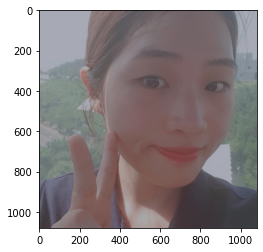

In [2]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/9.jpg'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지 불러옴
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관

# 색상 보정해주기 BGR =>RGB순으로 변경해줌
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

#출력해보기
plt.imshow(img_rgb)
plt.show()

### 2.1)얼굴 위치 찾기 (bounding box 위치 찾기)


rectangles[[(354, 133) (1019, 798)]]


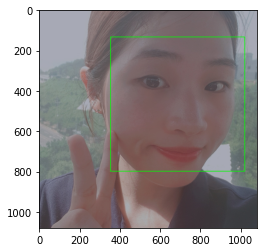

In [3]:
# hog detector 선언
detector_hog = dlib.get_frontal_face_detector()


dlib_rects = detector_hog(img_rgb, 1)   
# detector_hog(image, num of image pyramid(이미지 파라미터수))

# 얼굴의 좌표 출력
print(dlib_rects) 

# 얼굴에 bounding box 그리기
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### 2.2) 얼굴에 랜드 마크 (face landmark localization) 생성하기

68


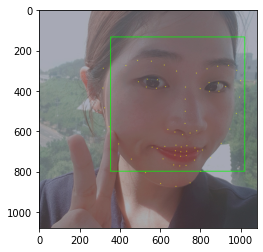

In [4]:
# 저장한 landmark모델 불러오기
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

#landmark_predictor 는 RGB 이미지와 dlib.rectangle을 입력 받아 dlib.full_object_detection 를 반환

list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0])) #68개의 랜드 마크가 생성됨

#  랜드 마크 영상 출력하기

for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## Step 3. 스티커 적용 위치 확인하기
    - landmark를 사용해서 계산하기

In [5]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # 코의 index는 30 입니다  / 코의 중심점 위치
    x = landmark[30][0]
    y = landmark[30][1]# - dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))
    

(723, 561)
(x,y) : (723,561)
(w,h) : (666,666)


In [6]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(666, 666, 3)


In [7]:
refined_x = x - w // 2
refined_y = y - h//2
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (390,228)


In [8]:
# 스티커 이미지가 원본 이미지 범위를 넘어가면 스티커 이미지를 원본에 맞춰 크롭함
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))


(x,y) : (390,228)


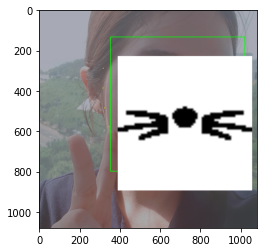

In [9]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==1,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

## Step 4. 스티커 적용하기
    1) np.where을 이용해 스티커 적용하기
    2) 스티커 투명도 조절하기 (참조. opencv=> cv2.addWeighted())
    https://www.youtube.com/watch?v=FTSgFFQGkho

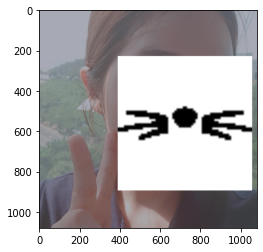

In [10]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==1,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

## 스티커를 자연스럽게 만들기


In [11]:
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지 불러옴
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관

# 색상 보정해주기 BGR =>RGB순으로 변경해줌
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

etector_hog = dlib.get_frontal_face_detector()


dlib_rects = detector_hog(img_rgb, 1)   
# detector_hog(image, num of image pyramid(이미지 파라미터수))


# 얼굴에 bounding box 그리기
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
landmark_predictor = dlib.shape_predictor(model_path)

#landmark_predictor 는 RGB 이미지와 dlib.rectangle을 입력 받아 dlib.full_object_detection 를 반환

list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)


#  랜드 마크 영상 출력하기

for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)


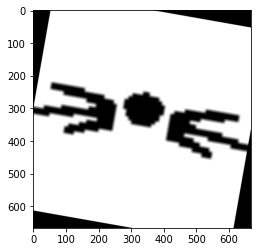

In [12]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))

cp = (w/2, h/2)
rotation = cv2.getRotationMatrix2D(cp, 350,1)
rotated_img = cv2.warpAffine(img_sticker, rotation, (w,h))
plt.imshow(rotated_img)

In [13]:
refined_x = x - w // 2
refined_y = y-h //2
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (390,228)


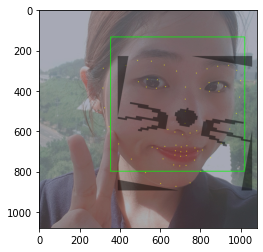

In [14]:
# 회전 시킨걸 적용해봄 => 검은 색 바탕 때문에 사용이 어려울 것 같음 
sticker_area = img_show[refined_y:refined_y+rotated_img.shape[0], refined_x:refined_x+rotated_img.shape[1]]
img_show[refined_y:refined_y+rotated_img.shape[0], refined_x:refined_x+rotated_img.shape[1]] = \
        np.where(rotated_img==0, cv2.addWeighted(sticker_area, 0.5,rotated_img, 0.5, 0), sticker_area).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

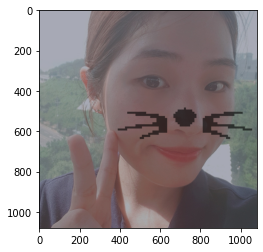

In [15]:
#회전 시키지 않은 버전으로 출력함
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
        np.where(img_sticker==0, cv2.addWeighted(sticker_area, 0.4, img_sticker, 0.6, 0), sticker_area).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

 ## 알게된 것
 
 1) cv2.addWeighted() 
 
     - 가중치 합, 평균연산 :같은 위치에 존재하는 픽셀 값에 대하여
         가중합을 계산하여 결과 영상의 픽셀 값으로 설정
     - cv2.addWeighted(src1, alpha, src2, beta, gamma, dst=None, dtype=None)
         - src1: (입력) 첫 번째 영상
         - alpha: 첫 번째 영상 가중치
         - src2: 두 번째 영상. src1과 같은 크기 & 같은 타입
         - beta: 두 번째 영상 가중치
         - gamma: 결과 영상에 추가적으로 더할 값
         - dst: 가중치 합 결과 영상
         - dtype: 출력 영상(dst)의 타입
         
 이론 참고_https://deep-learning-study.tistory.com/115
 
 ------------------------------------------------------
 
 2) cv2.getRotationMatrix2D()

    - 회전 변환 : 영상을 특정 각도만큼 변환 시킴(반시계 방향)
    - 영상의 중앙을 기준점으로 회전 시킴
    - 함수 설명_cv2.getRotationMatrix2D(center, angle, scale) -> retval
         - center: 회전 중심 좌표. (x, y) 튜플.
         - angle: (반시계 방향) 회전 각도(degree). 음수는 시계 방향.
         - scale: 추가적인 확대 비율
         - retval: 2x3 어파인 변환 행렬. 실수형
         
이론 참고_https://deep-learning-study.tistory.com/199
        
---------------------------------------------

3) 이미지 돌리기& 투명도 조절 코드 참고

https://m.blog.naver.com/totoro772/222622170248

---------------------------------------

4) dlib detecto 특성

     - dlib detector 는 dlib.rectangles 타입의 객체를 반환
     - dlib.rectangles 는 dlib.rectangle 객체의 배열 형태로 이루어짐
     - dlib.rectangle객체의 함수: left(), top(), right(), bottom(), height(), width()
     
-------------------
5) where 함수
    - 특정 조건에 맞는 원소의 위치를 반환
    - 특정 조건에 맞는 원소와 그렇지 않은 원소를 원하는 값으로 변경
    
    5.1) .astype()
        - Array를 통채로 형을 변환할때 사용함
     
 


# Step5. 문제점 찾아보기
    1) 다양한 각도에서 찰영한 사진으로 스티커 반복 적용
    
    2) 문제점이 무엇인지 최대한 자세하게 기록
        - 얼굴각도에 따라 스티커가 어떻게 변해야 할까?
        - 멀리서 촬용하면 안되는 이유
        - 실행 속도 중요?
        - 스티커 앱을 만들 때 정확도가 얼마나 중요할까?

스티커 투명도 조절하기

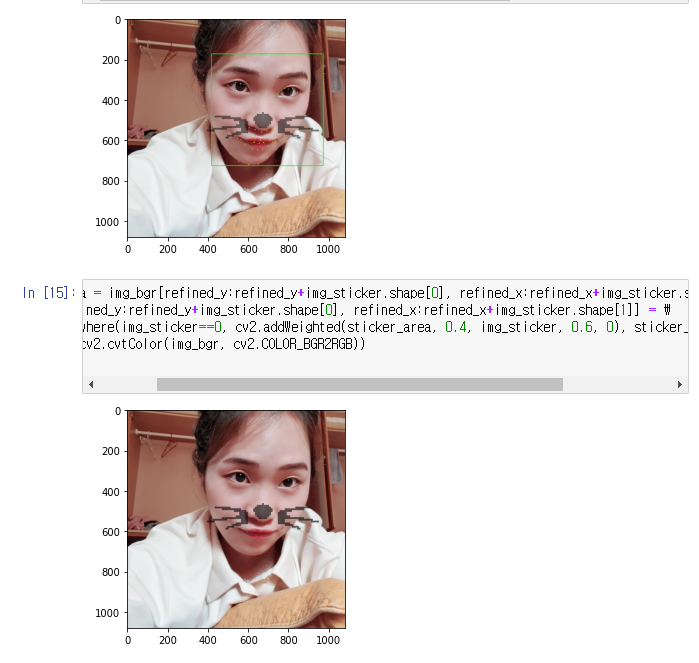



# 다양한 각도의 사진
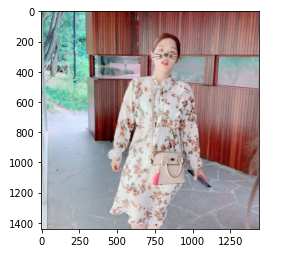

    사진유형) 얼굴이 보이는 전신샷 : 얼굴의 범위를 살짝 벗어남 & 각도가 틀어짐


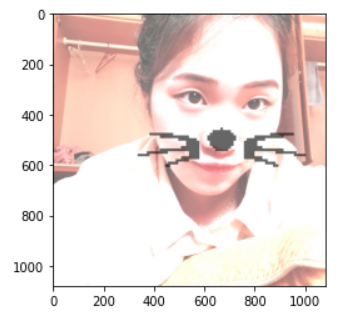 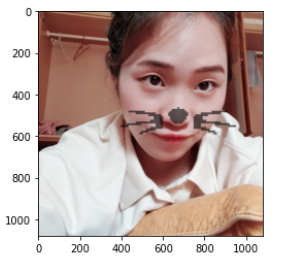
사진 유형) 위에서 찍은 사진 & 밝기 변경
    :각도가 안맞음 밝기에 따른 변화는 모르겠음 (밝은게 스티커가 살짝 더 잘보이는 느낌)

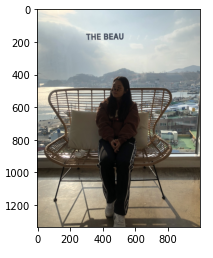
사진 유형) 어두운 전신사진 : 너무 어두워서 스티커 확인불가

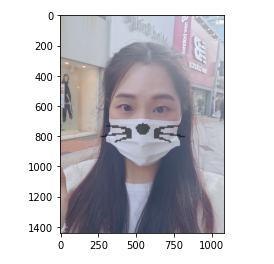
사진유형)정면& 마스크 착용 : 얼굴보다 더 넓은 범위가 인식되서 얼굴보다 스티커가 더 큼

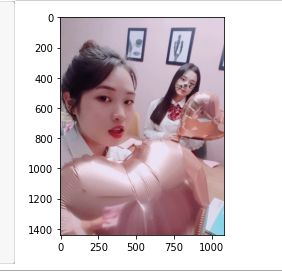
사진유형) 2명 한명은 측면 & 한명은 비교적 정면

---------------------------

## 내가 생각하는 문제점

    1. 얼굴 인식 부분
        - 마스크를 쓴 사진
        - 측면 사진
        - 어두운 사진
        - 위에서 찍은 사진
        - 얼굴이 너무 작게 나온 사진
        => 얼굴의보다 더 넓거나 작은 범위를 얼굴로 인식했다.
        => 특히 심한 측면 사진의 코의 위치도 정확하게 인식되지 않았다.
        
    2. 스티커를 붙이는 것
        - 셀카를 찍을때 정면으로 찍는 사진은 별로 없는데 이러한 방식으로 스티커를
          붙이게 되면 얼굴 각도에 따라 스티커의 각도를 조정해주어야한다는 문제가 
          발생하였다.
          
--------------------------------

## [질문]
    1. 스티커의 투명도를 조절하기 전에는 np.where()에서 mg_sticker== 부분이 1이어야 코부분이 검정색으로 보였는데 투명도를 조절하기 1로 변경하면 스티커가 보이지 않는이유?
    
    2.cv2.addWeighted()에서 스케일이 다른데 이미지가 합성 될수 있었던 이유?
    
    3. 인식은 둘다 되는데 스티커는 왜 한명만 적용되는지?
   
        ->만약 하나만 그리도록 된 것이면 왜 얼굴이 큰 내얼굴이 아니라 
            작게 나온 친구 사진에 스티커가 적용된건지?
            => 측면사진이여서 인식이 안되는 건가? 
                정면을 보고 있는 여러명이 나온 사진을 적용
            => 역시 하나의 사진에만 적용됨 스티커가 그러질 얼굴의 기준은 뭘까>
            
-------------------

## [해결방법은 무엇일까?]
 
 -스티커 이미지를 cv2.getRotationMatrix2D를 이용해 돌리니 검은 색 배경이 생겼다. 이를 해결하기 위해 이미지의 크기를 확대하면 스티커가 너무 커지거나 스티커 이미지가 일부 잘리는 문제가 발생하였다.
    

----------------------

## 회고


스티커를 자연스럽게 하는 방법을 조사하기 위해 힌트였던  addWeighted() 메서드에 대해 공부하고 이제 적용해 봐야지! 하는데 두 사진의 크기가 달라서 적용할 수 없다는 경고 문구가 떴다. 그래서 더 조사해 봤는데 저 메서드를 쓴 예시들이 다 사진의 크기가 같았고 같은 크기의 이미지를 만들어 줘야한다고 나와있었다.
 왜 저렇게 하면 이미지가 작게 적용되는지 이해가 안됐다. 그래서 np.where을 몰라서 이해를 못하는 것 같아 그것도 공부해 봤는데 아직도 모르겟다😭
